In [77]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

### CEC- Clique-Motif Eigenvalue Centrality

Calculate the CEC centrality measure for the Example hypergraph of the report using power method and SVD approach.


#### Note:

Please see the notebook "erdos_renyi_centrality_correlations.ipynb" for full documentation of the functions used.

In [78]:
# generate hypergraph

H = UndirectedHypergraph()
H.add_nodes([1,2,3,4,5,6,7,8,9,10,11])
H.add_hyperedge([1,2,3])
H.add_hyperedge([4,5,3])
H.add_hyperedge([3, 6])
H.add_hyperedge([6,7,8,9,10,11])

node_map = undirected_matrices.get_node_mapping(H)[1]
edge_map = undirected_matrices.get_hyperedge_id_mapping(H)[1]

I = undirected_matrices.get_incidence_matrix(H, node_map, edge_map).toarray()
np.shape(I)

(11, 4)

In [79]:
A = I @ I.T # hyperadjacency matrix

In [80]:
A

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]], dtype=int32)

In [101]:
# calculate the CEC centrality


# using SVD approach

def compute_cec_ranking_svd(A):
    # using best rank one approximation
    rank = 1

    # Perform SVD adjacency matrix
    U, D, Q = np.linalg.svd(A, full_matrices=True)
    
    return U[:, :rank].T[0]


# using eigenvalue/eigenvector approach

def compute_cec_ranking_power(A, num_sims):
    # implementing the power method
    # code altered from: https://en.wikipedia.org/wiki/Power_iteration
    b_k = np.random.rand(len(A))

    for _ in range(num_sims):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1) # normalise using 1-norm as explained in report.

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [93]:
c_svd = compute_cec_ranking_svd(A)
c = compute_cec_ranking_power(A, 100)

svd_decomp = np.outer(c_svd, c_svd)

In [94]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib import ticker

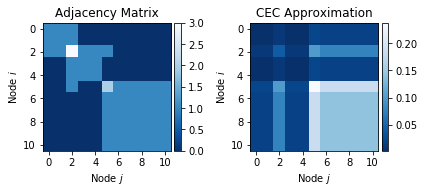

In [95]:
# compare how the actual adjacency matrix and its rank-1 approximation

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('Adjacency Matrix')
im1 = ax1.imshow(A, cmap = "Blues_r")
ax1.set_ylabel("Node $i$")
ax1.set_xlabel("Node $j$")
xticks = ticker.MaxNLocator(6)
ax1.xaxis.set_major_locator(xticks)


divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)


ax2.set_title("CEC Approximation")
im2 = ax2.imshow(svd_decomp, cmap = "Blues_r")
ax2.set_ylabel("Node $i$")
ax2.set_xlabel("Node $j$")
xticks = ticker.MaxNLocator(6)
ax2.xaxis.set_major_locator(xticks)


divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

fig.tight_layout()

#plt.savefig('imgs/CEC_approximation_heatmap.pdf', bbox_inches = "tight")

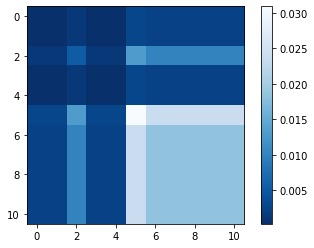

In [89]:
plt.imshow(np.outer(c, c), cmap = "Blues_r")
plt.colorbar()

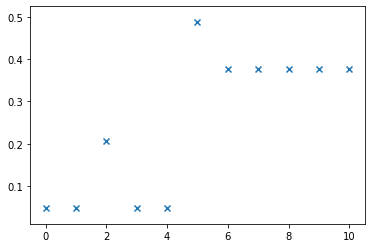

In [58]:
plt.scatter(range(11), c, marker = "x")

In [110]:
# testing where the SVD or power method is faster 
import time

A_ = np.random.rand(1000, 1000)

s1 = time.time()
c_svd = np.abs(compute_cec_ranking_svd(A_))
c_svd = c_svd / c_svd.sum()
e1 = time.time()

s2 = time.time()
c = compute_cec_ranking_power(A_, 1000)
c = c/c.sum()
e2 = time.time()

print("SVD: " + str(e2 - s2))
print("Power: " + str(e1 - s1))

SVD: 0.13663649559020996
Power: 0.22340154647827148


In [111]:
# check they give same result

np.linalg.norm(c_svd - c)

1.5294180802060853e-05

## General centrality - Not used

In [61]:
def general_centrality(I, beta_1, beta_2):
    
    a = np.zeros(len(I))
    b = np.zeros(len(I))
    
    for k in range(100):
        a += np.linalg.matrix_power(beta_1*beta_2* I @ I.T, k) @ I.dot(np.ones(len(I[0])))
        b += ((beta_1*beta_2)**k) * np.linalg.matrix_power(I @ I.T, k+1).dot(np.ones(len(I)))
    return a + beta_1*b

In [73]:
c_svd = compute_cec_ranking_svd(A)
c = compute_cec_ranking_power(A, 100)

svd_decomp = np.outer(c_svd, c_svd)

c = c/c.sum()

In [74]:
res = general_centrality(I, 0.8, 0.8)
res = res / res.sum()

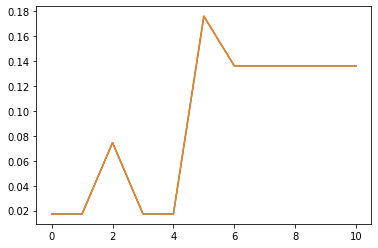

In [75]:
plt.plot(res)
plt.plot(c)

In [76]:
res

array([0.0173538 , 0.0173538 , 0.0744895 , 0.0173538 , 0.0173538 ,
       0.17583412, 0.13605223, 0.13605223, 0.13605223, 0.13605223,
       0.13605223])

In [70]:
c_svd

array([[-0.04808975],
       [-0.04808975],
       [-0.20642052],
       [-0.04808975],
       [-0.04808975],
       [-0.48726026],
       [-0.37701923],
       [-0.37701923],
       [-0.37701923],
       [-0.37701923],
       [-0.37701923]])